# Explore here

It's recommended to use this notebook for exploration purposes.

In [14]:
import os
from sqlalchemy import create_engine
import pandas as pd
from dotenv import load_dotenv
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
url = " https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue"
html_data = requests.get(url, time.sleep(10)).text

if "403 Forbidden" in html_data:
    headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"}
    request = requests.get(url, headers = headers)
    time.sleep(10)
    html_data = request.text

html_data

'<html>\r\n<head>\r\n\n</head>\r\n<body>\r\n<div style="margin: 50px auto; width: 50%; border: 1px solid #dfdfdf; padding: 20px 50px 30px 50px; font-family:helvetica;">\r\n\r\n<h1>We do not allow automated access to our servers.</h1>\r\n<h2><p>Automated access to our data is prohibited by our data provider.</p>  \r\n<p>If you are a user attempting to access the site via a browser, please follow this process to regain access:</p>\r\n\r\n<ul>\r\n  <li>Go to <a href=\'https://whatismyipaddress.com/\' target=\'_blank\' rel=\'noopener noreferrer\'>whatismyipaddress</a> and obtain your IPv4 address</li>\r\n  <li>Email us your IPv4 address at <a href="/cdn-cgi/l/email-protection" class="__cf_email__" data-cfemail="4821262e270825292b3a273c3a2d262c3b66262d3c">[email&#160;protected]</a></li>\r\n  <li>We will add you to our whitelist within 24 hours</li>\r\n</ul>\r\n</h2>\r\n</div>\r\n<script data-cfasync="false">!function(){"use strict";function e(e){try{if("undefined"==typeof console)return;"er

In [5]:
soup = BeautifulSoup(html_data,"html.parser")
soup
tables = soup.find_all("table")
tables

[]

In [6]:
for index, table in enumerate(tables):
    if ("Tesla Quarterly Revenue" in str(table)):
        table_index = index
        break

# Create a DataFrame
tesla_revenue = pd.DataFrame(columns = ["Date", "Revenue"])
for row in tables[table_index].tbody.find_all("tr"):
    col = row.find_all("td")
    if (col != []):
        Date = col[0].text
        Revenue = col[1].text.replace("$", "").replace(",", "")
        tesla_revenue = pd.concat([tesla_revenue, pd.DataFrame({
            "Date": Date,
            "Revenue": Revenue
        }, index = [0])], ignore_index = True)

tesla_revenue.head()

NameError: name 'table_index' is not defined

In [7]:
tesla_revenue = tesla_revenue[tesla_revenue["Revenue"] != ""]
tesla_revenue.head()

,Date,Revenue


In [9]:
connection = sqlite3.connect("Tesla.db")
connection

In [10]:
cursor = connection.cursor()
cursor.execute("""CREATE TABLE revenue (Date, Revenue)""")

In [11]:
tesla_tuples = list(tesla_revenue.to_records(index = False))
tesla_tuples[:5]

[]

In [12]:
cursor.executemany("INSERT INTO revenue VALUES (?,?)", tesla_tuples)
connection.commit()

In [13]:
for row in cursor.execute("SELECT * FROM revenue"):
    print(row)

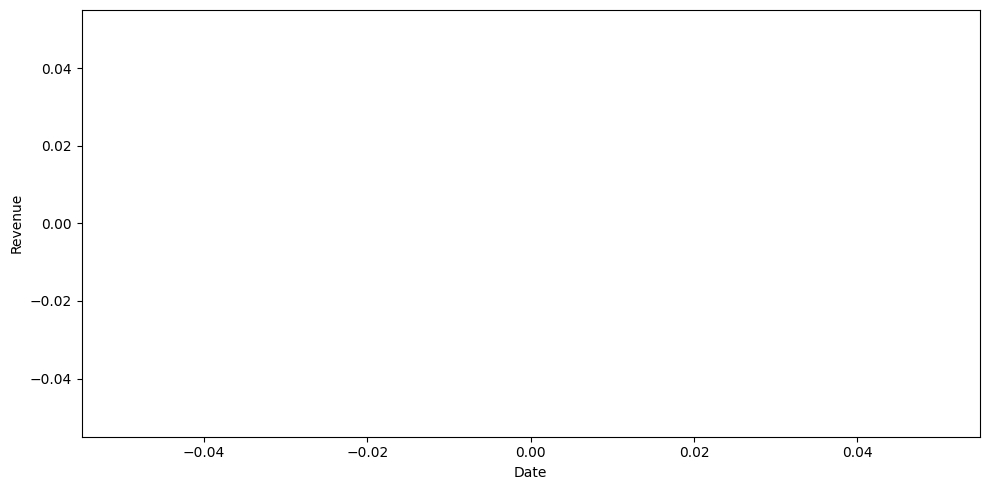

In [15]:
fig, axis = plt.subplots(figsize = (10, 5))

tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"])
tesla_revenue["Revenue"] = tesla_revenue["Revenue"].astype('int')
sns.lineplot(data = tesla_revenue, x = "Date", y = "Revenue")

plt.tight_layout()

plt.show()

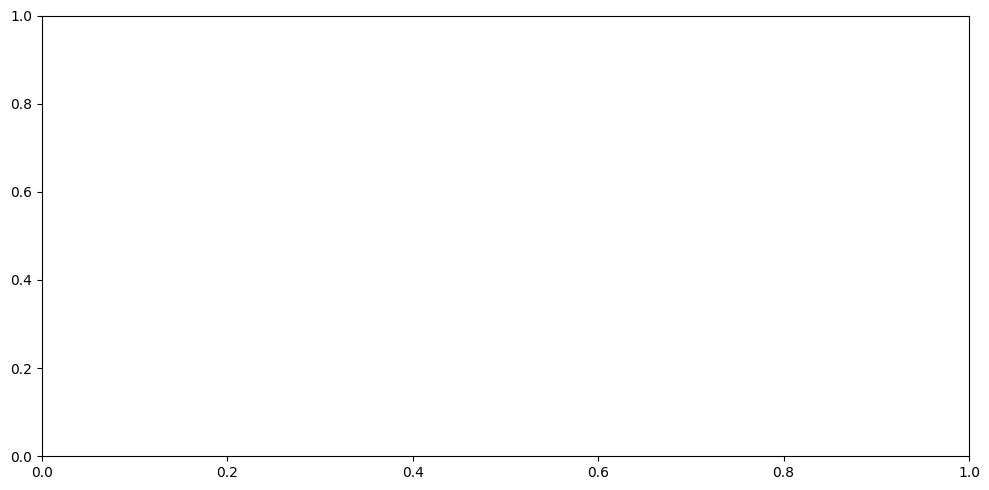

In [16]:
fig, axis = plt.subplots(figsize = (10, 5))

tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"])
tesla_revenue_yearly = tesla_revenue.groupby(tesla_revenue["Date"].dt.year).sum().reset_index()

sns.barplot(data = tesla_revenue_yearly[tesla_revenue_yearly["Date"] < 2023], x = "Date", y = "Revenue")

plt.tight_layout()

plt.show()

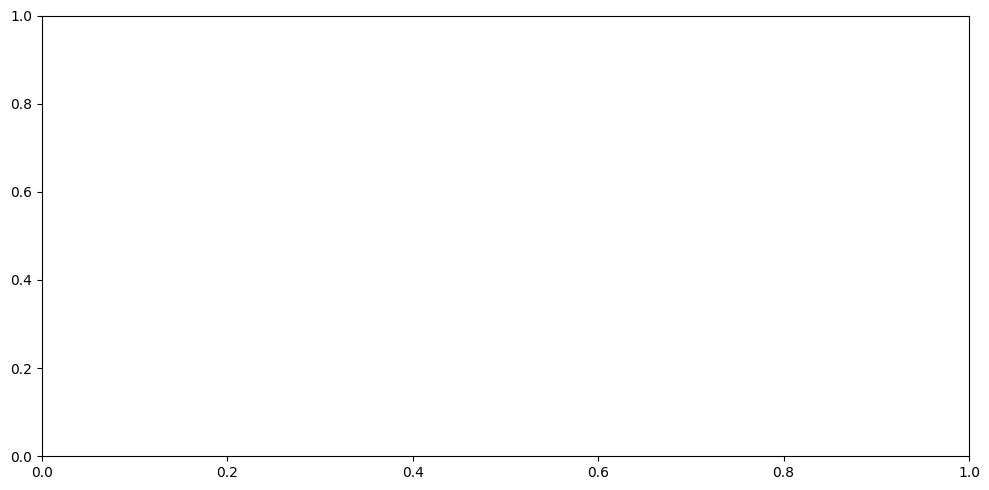

In [17]:
fig, axis = plt.subplots(figsize = (10, 5))

tesla_revenue_monthly = tesla_revenue.groupby(tesla_revenue["Date"].dt.month).sum().reset_index()

sns.barplot(data = tesla_revenue_monthly, x = "Date", y = "Revenue")

plt.tight_layout()

plt.show()